In [1]:
import torch as th
import numpy as np
from matplotlib import pyplot as plt

In [2]:
save_as = "not_reg_1024"
suptitle = "umap"
title = "umap"

In [3]:
hidden_activations = th.load(f"./activations/hidden_activ_{save_as}.pt")
output_activations = th.load(f"./activations/output_activ_{save_as}.pt")
predicted = th.load(f"./predicted/{save_as}.pt")

hidden_activations = hidden_activations.numpy()
output_activations = output_activations.numpy()
predicted = predicted.numpy()

In [4]:
hidden_layer_neurons = hidden_activations.shape[1]

https://arxiv.org/pdf/2108.05525.pdf

https://umap-learn.readthedocs.io/en/latest/mutual_nn_umap.html


In [5]:
import umap

reducer = umap.UMAP(n_neighbors=20, n_components=2)

projection = reducer.fit_transform(output_activations)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

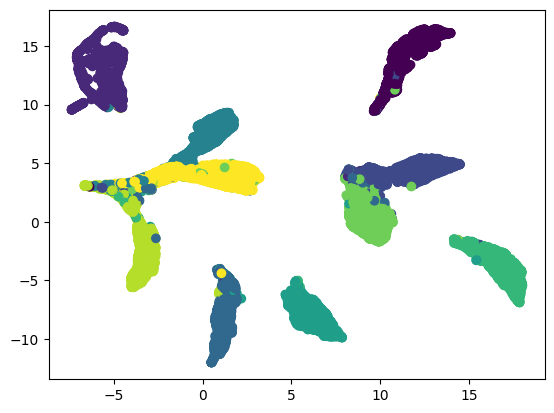

In [6]:
plt.scatter(projection[:, 0], projection[:, 1], c=predicted)

In [7]:
from sklearn.cluster import KMeans

umap_labels = KMeans(n_clusters=10).fit_predict(projection)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
umap_indexes = []  # stores indexes of test point in each cluster
associations = (
    []
)  # associations[i] is a tuple with the label associated with i-th cluster, with the given probability
for i in range(10):
    umap_cluster = np.where(umap_labels == i)[0]
    umap_indexes.append(umap_cluster)

    labels, freq = np.unique(predicted[umap_cluster[i]], return_counts=True)
    print(
        f"KMEANS CLUSTER {i}. Labels:{labels}. Frequency: {freq} ---> Cluster {i} associated with label {labels[np.argmax(freq)]} with prob. {100*np.max(freq)/np.sum(freq)}%"
    )
    associations.append((labels[np.argmax(freq)], np.max(freq) / np.sum(freq)))

KMEANS CLUSTER 0. Labels:[2]. Frequency: [1] ---> Cluster 0 associated with label 2 with prob. 100.0%
KMEANS CLUSTER 1. Labels:[8]. Frequency: [1] ---> Cluster 1 associated with label 8 with prob. 100.0%
KMEANS CLUSTER 2. Labels:[9]. Frequency: [1] ---> Cluster 2 associated with label 9 with prob. 100.0%
KMEANS CLUSTER 3. Labels:[1]. Frequency: [1] ---> Cluster 3 associated with label 1 with prob. 100.0%
KMEANS CLUSTER 4. Labels:[5]. Frequency: [1] ---> Cluster 4 associated with label 5 with prob. 100.0%
KMEANS CLUSTER 5. Labels:[0]. Frequency: [1] ---> Cluster 5 associated with label 0 with prob. 100.0%
KMEANS CLUSTER 6. Labels:[6]. Frequency: [1] ---> Cluster 6 associated with label 6 with prob. 100.0%
KMEANS CLUSTER 7. Labels:[3]. Frequency: [1] ---> Cluster 7 associated with label 3 with prob. 100.0%
KMEANS CLUSTER 8. Labels:[3]. Frequency: [1] ---> Cluster 8 associated with label 3 with prob. 100.0%
KMEANS CLUSTER 9. Labels:[9]. Frequency: [1] ---> Cluster 9 associated with label 

In [9]:
# store the hidden activations for each of the 10 cluster:
hidden_activ_per_clusters = []

for i in range(10):
    # seleziono le hidden activation dei test point corrispondenti
    hidden_activ_per_clusters.append(hidden_activations[umap_indexes[i]])

kmeans_indexes[0] stores the index of the test point in cluster 0


In [10]:
top_activations = [[] for _ in range(10)]
for i in range(10):
    for j in range(hidden_activ_per_clusters[i].shape[0]):
        top_activations[i].append(hidden_activ_per_clusters[i][j].argsort()[-5:][::-1])

In [11]:
neurons_IDs = []  # gli interi qui dentro corrispondono all'ID di un neurone
frequencies = []

for i in range(10):
    values, counts = np.unique(
        np.stack(top_activations[i]).flatten(), return_counts=True
    )
    neurons_IDs.append(values)
    frequencies.append(counts)

In [12]:
best_neurons_per_cluster = []
for i in range(10):
    idxs = list(frequencies[i].argsort()[-5:][::-1])
    best_neurons_per_cluster.append(neurons_IDs[i][idxs])

best_neurons_per_cluster

[array([878, 260, 321, 354, 371]),
 array([354, 455, 628, 295, 861]),
 array([945, 234, 296, 712, 981]),
 array([312, 445, 462, 455, 354]),
 array([310, 855, 432,  51, 354]),
 array([840, 278, 785, 166, 786]),
 array([533, 260, 259, 987,  51]),
 array([371, 945, 931, 428, 234]),
 array([310, 432, 959, 628, 878]),
 array([354, 945, 234, 296, 432])]

## Resulting plot


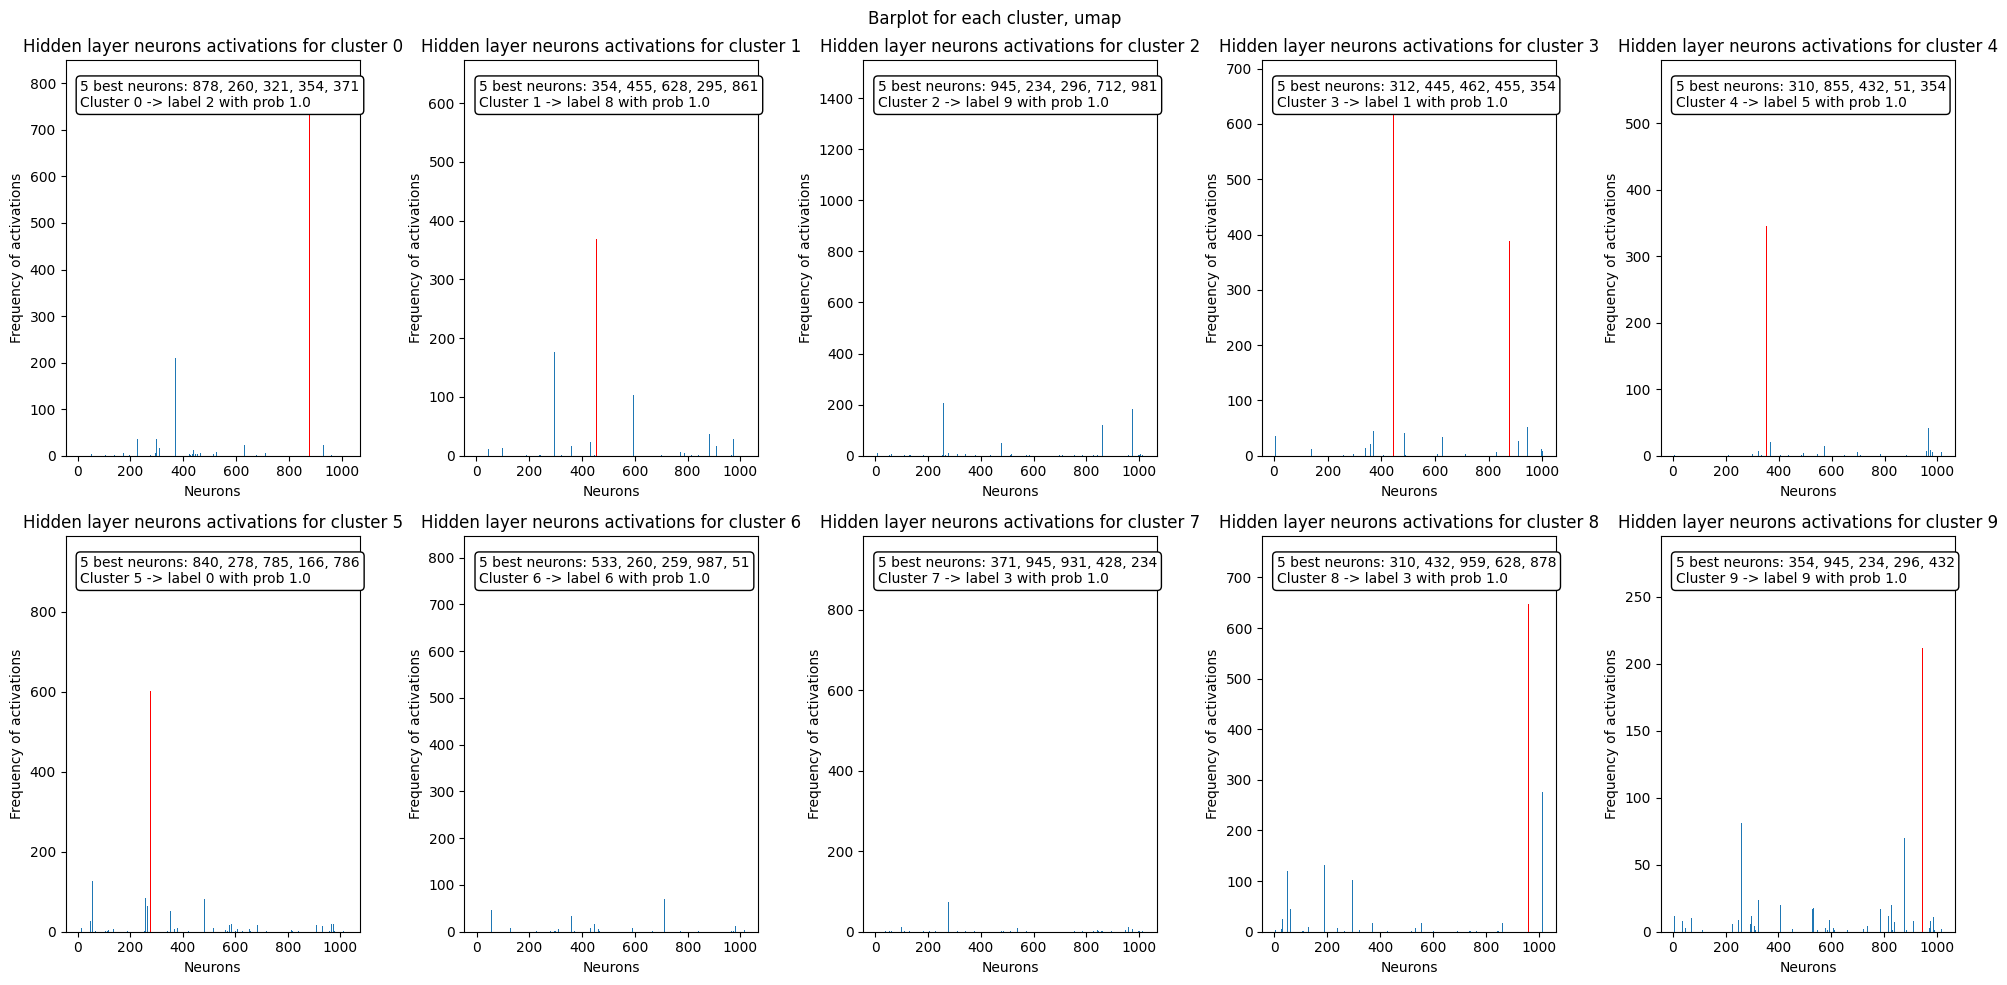

In [13]:
from src.evaluation import barplot_grid, heatmap

barplot_grid(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    suptitle=suptitle,
    save_as=save_as,
)

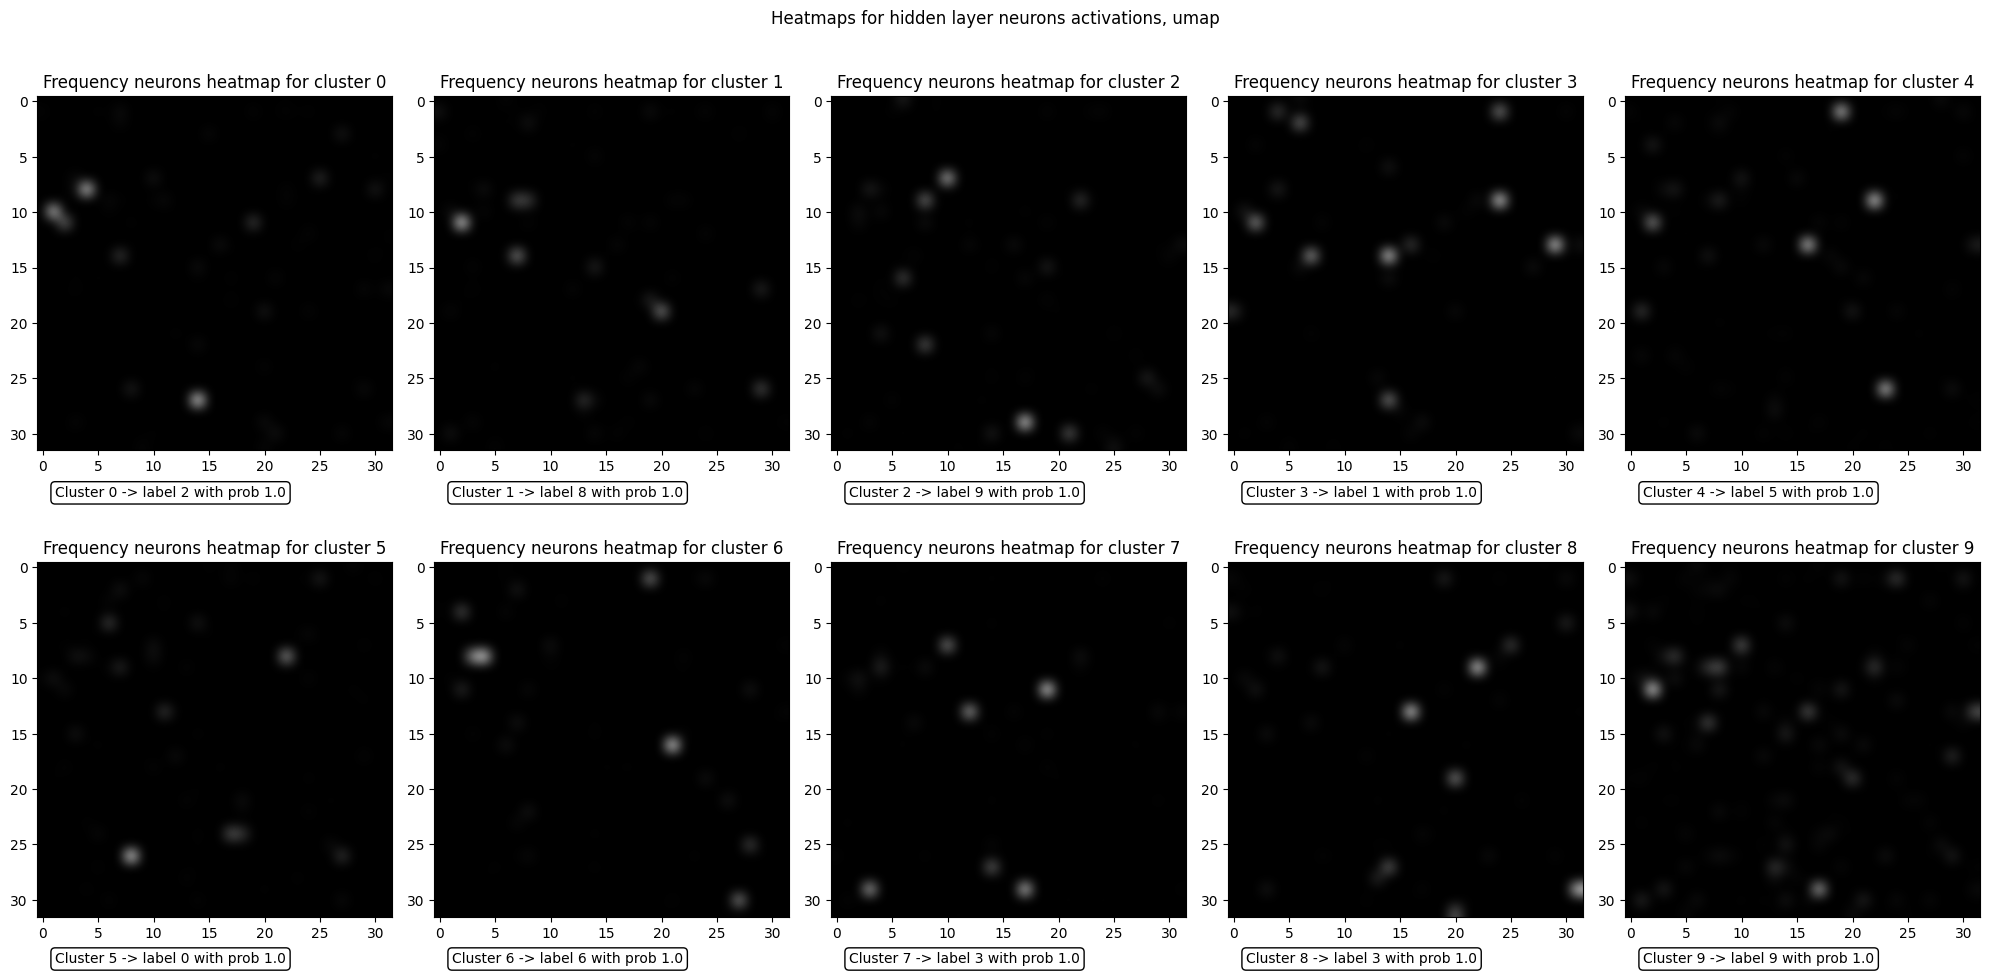

In [14]:
heatmap(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    suptitle=suptitle,
    save_as=save_as,
)

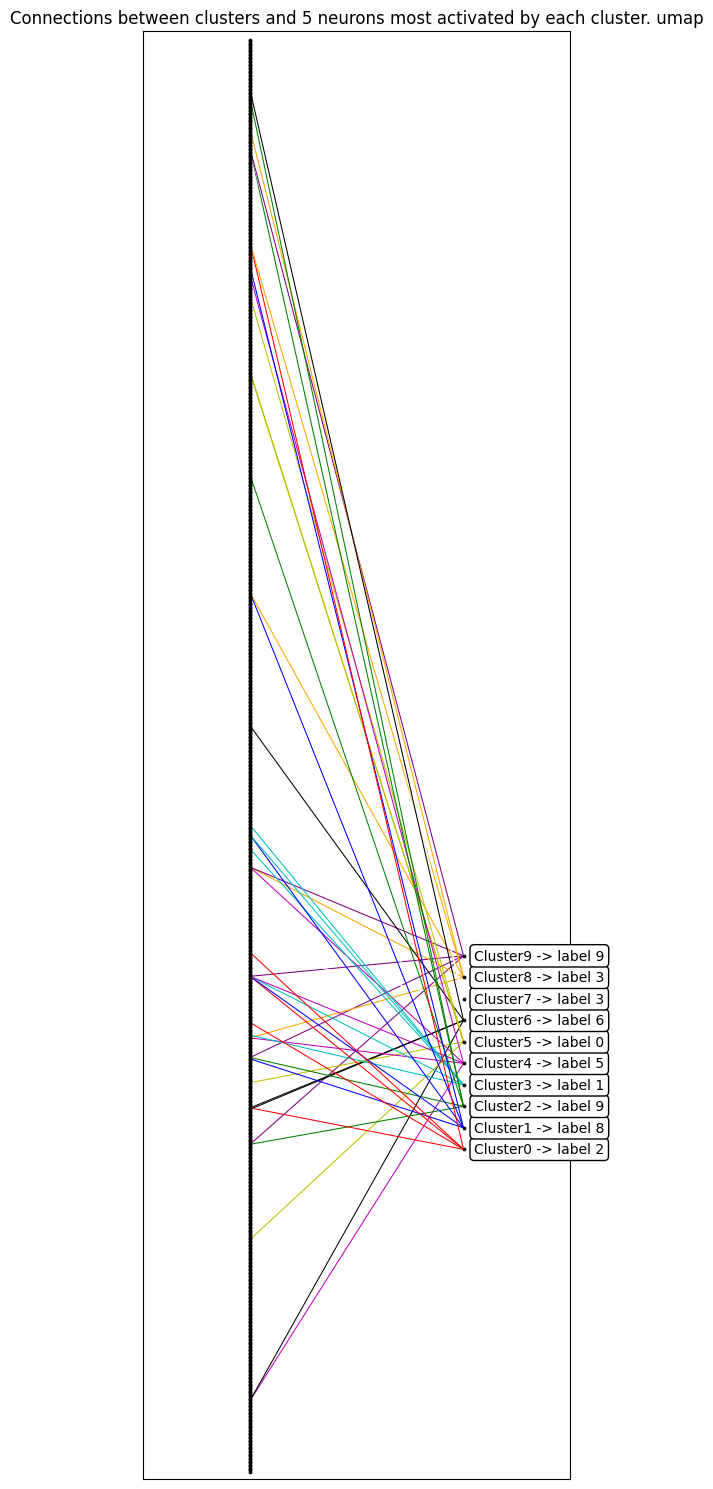

In [15]:
from src.evaluation import connections

connections(
    best_neurons_per_cluster=best_neurons_per_cluster,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    title=title,
    save_as=save_as,
)

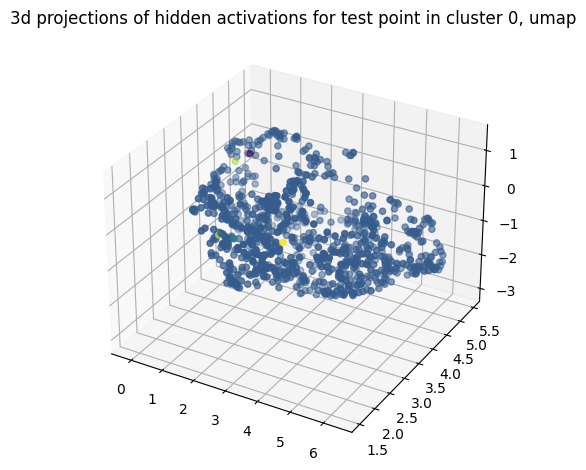

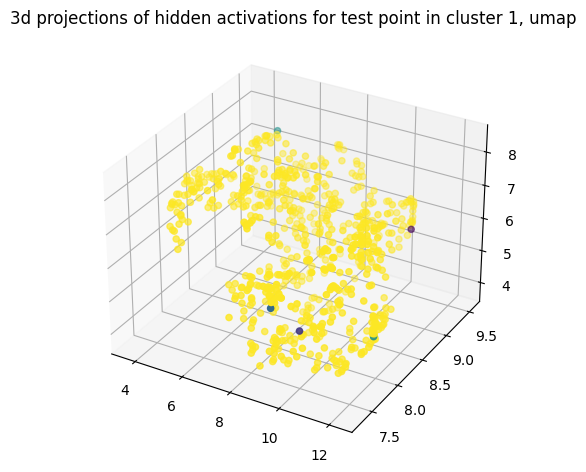

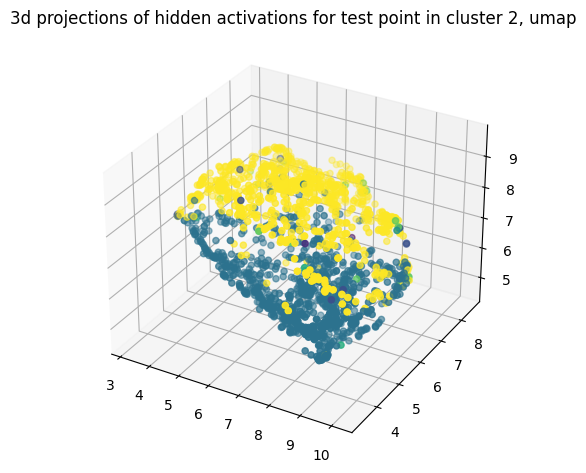

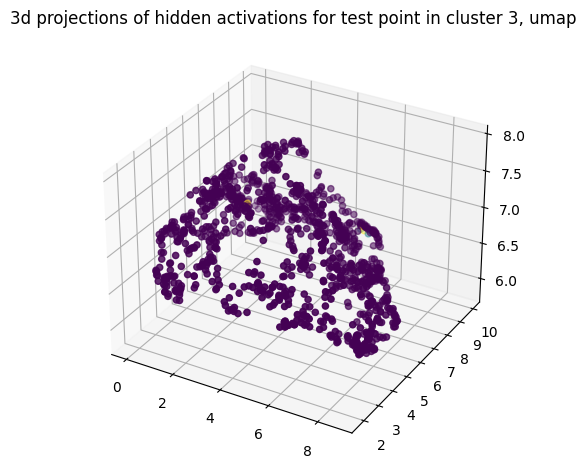

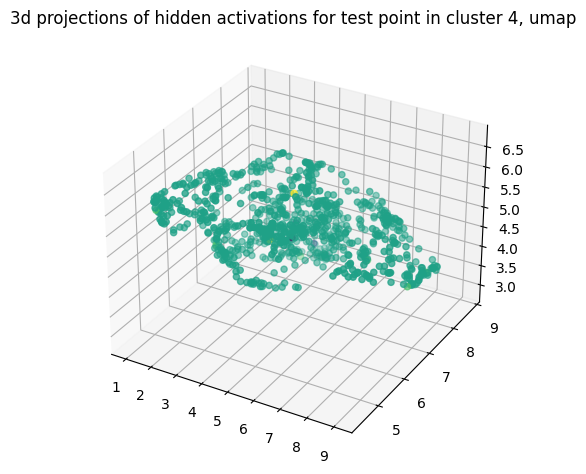

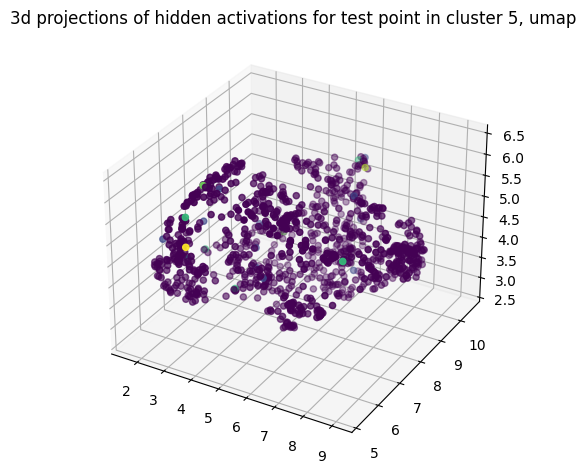

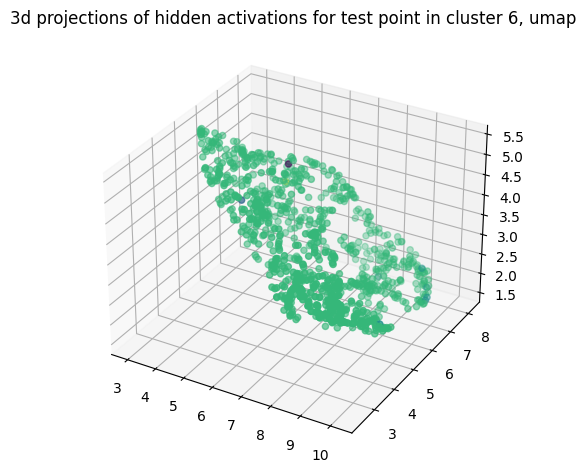

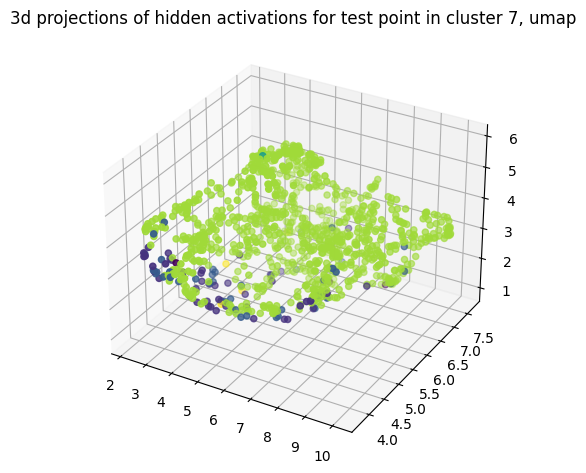

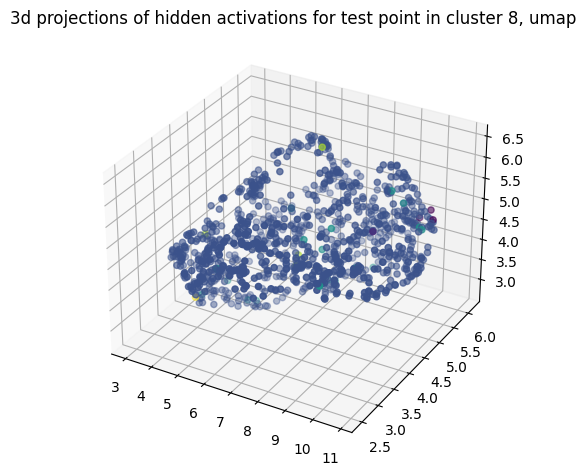

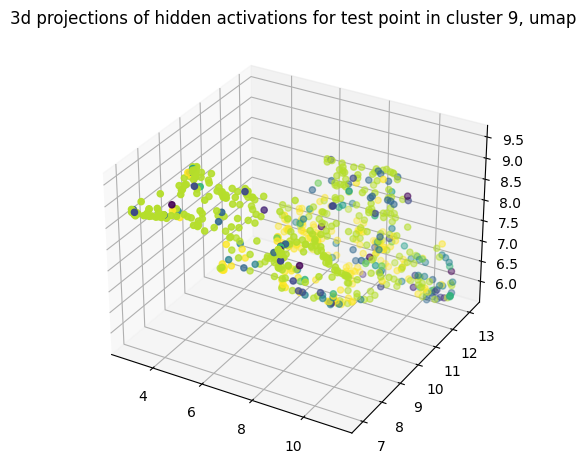

In [16]:
import matplotlib.pyplot as plt
from src.plot_manifold import plot_manifold


for i in range(10):
    plot_manifold(
        data=hidden_activations[umap_indexes[i]],
        i=i,
        title=title,
        predicted=predicted[umap_indexes[i]],
        save_as=save_as,
    )

    plt.show()

In [17]:
weights_first_layer = th.load(f"./weights/weights_first_layer_{save_as}.pt")

weights_first_layer = weights_first_layer.numpy()

weights_per_cluster = (
    []
)  # weights_per_cluster[i] stores the weights for the 5 'best' neurons in the i-th cluster. (nb consider the weights che uniscono il primo layer al neurone del secondo layer)
for i in range(10):
    weights_per_cluster.append(weights_first_layer[best_neurons_per_cluster[i]])

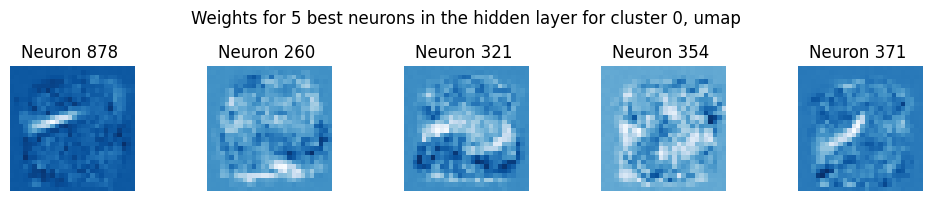

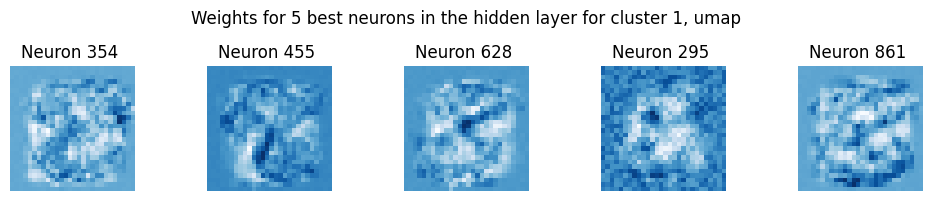

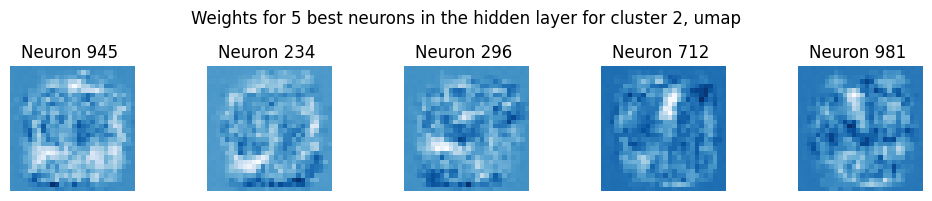

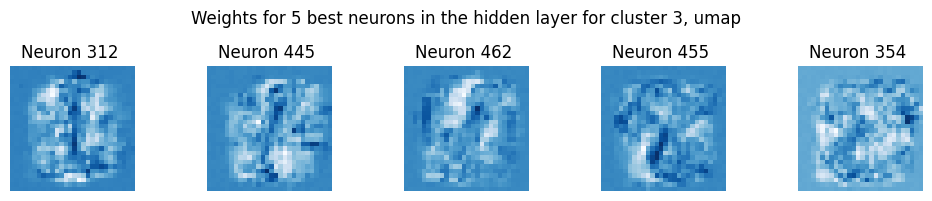

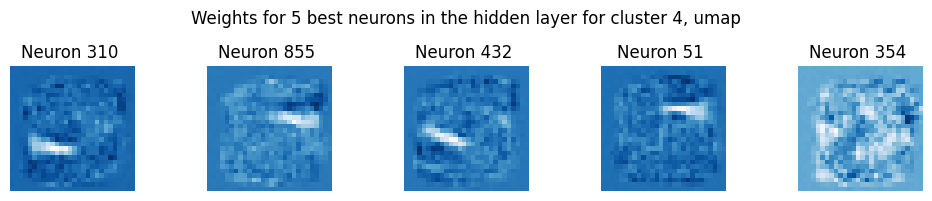

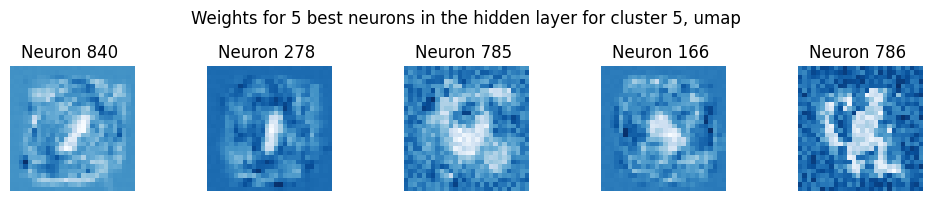

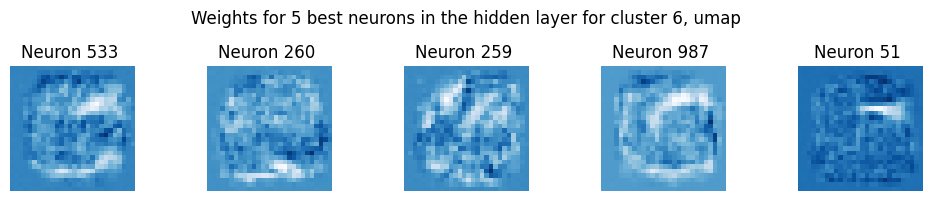

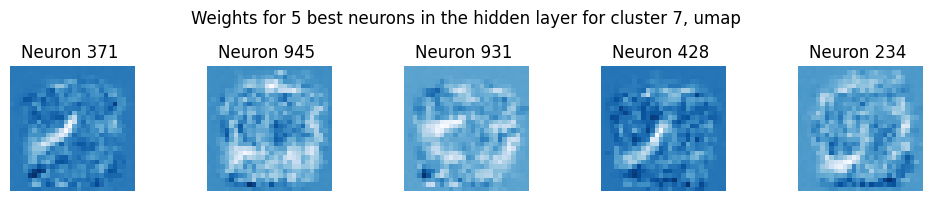

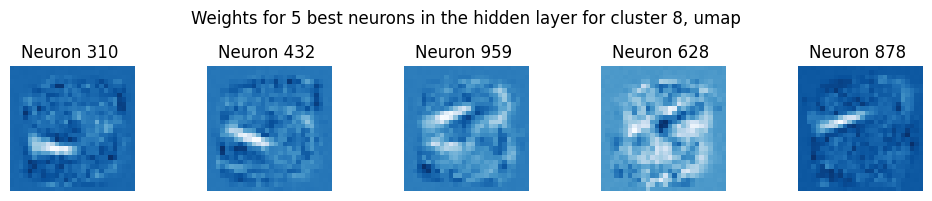

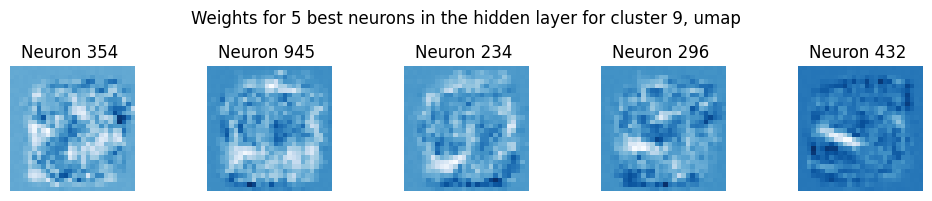

In [18]:
from src.evaluation import plot_weights

plot_weights(
    weights_per_cluster=weights_per_cluster,
    best_neurons_per_cluster=best_neurons_per_cluster,
    title=title,
    save_as=save_as,
)

In [19]:
%store -r test_loader

Take the first image (7), and study how the network 'see' this image by filtering using the corresponding best neurons from clusters associated with label 7.


image with index 3 has label 0, which is associated with cluster(s): [5] 


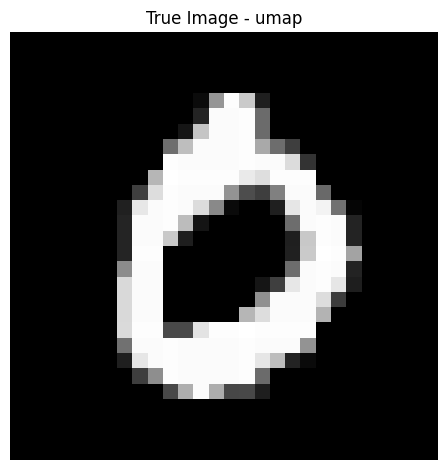

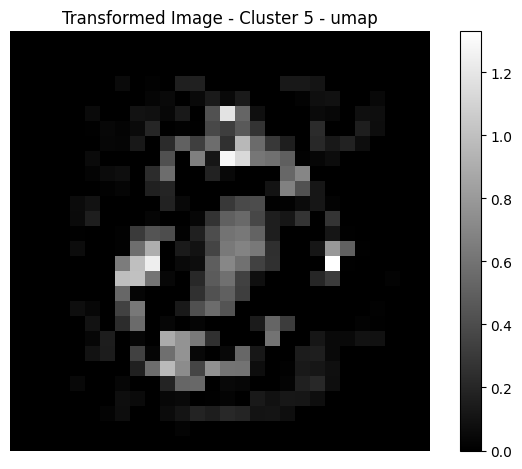

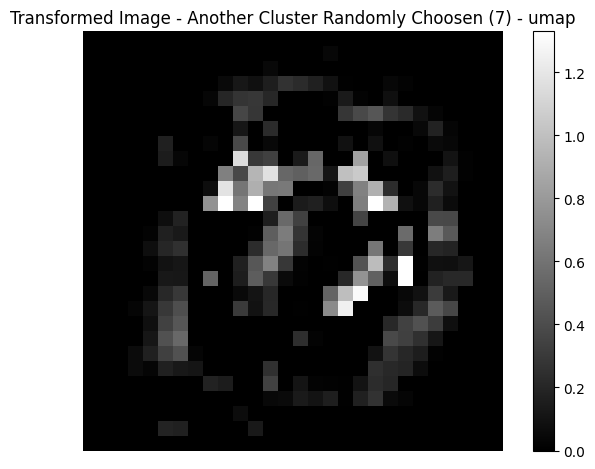

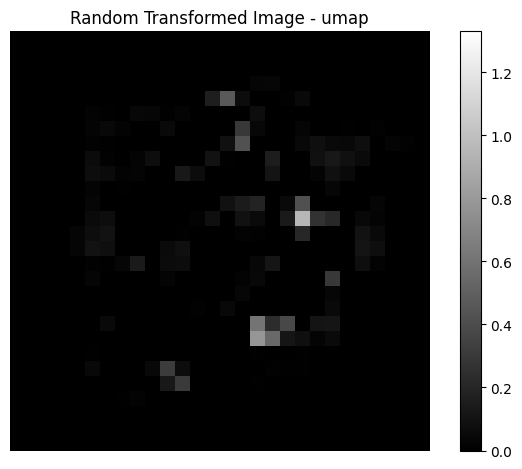

------------------------------------------------------------------------


In [21]:
from src.evaluation import neurons_reconstruction


neurons_reconstruction(
    image_index=3,
    test_loader=test_loader,
    associations=associations,
    weights_per_cluster=weights_per_cluster,
    weights_first_layer=weights_first_layer,
    save=True,
    save_as=save_as,
    title=title,
)